# Document Classification with Word Embeddings

In this previous activity, we have enough fun playinng around the word embeddings. 
Now, we get to the stage that we will make real use of them, i.e., we are going to build on these embeddings machine learing models for document classification. 😊


## The Dataset
Same as in the previous activity, the document collection that we are going to use is the BBC News Dataset. For the origin of the dataset, please refer to [here](http://mlg.ucd.ie/datasets/bbc.html)
To be brief, the dataset consists of 2225 documents from the BBC news website corresponding to stories in five topical areas, i.e., class Labels (business, entertainment, politics, sport, tech).

In this activity, instead of using the raw dataset, we will utilised the pre-processed clean dataset we saved in our previous Activity 3 Generating Feature Vectors.
Recall that at the end of Activity 3, we saved the pre-processed articles in a txt file named `bbcNews.txt`, where, each row is a document, with tokens seperated by whitespace.

Before continue, please make sure you have the following files in the same folder as this jupyter notebook:
* `bbcNews.txt`: contains the pre-process BBC news articles
* `labels.csv`: contains the label/class of each article.

In [1]:
from itertools import chain
from nltk.probability import *
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# import code as a function
from src.utils import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# ignore warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
# logging for event tracking
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Let's read in the labels and article data, and construct a single dataframe to store them correspondingly. 
Note that the order of the articles are the same as the labels data, as they are all in sorted order of document names. 

In [3]:
# Read job_ad.csv
job_ad = pd.read_csv('job_ad.csv')

# # get the description of the job ad
# description = job_ad['Description']
# # get the tokenized description of the job ad
# tk_description = job_ad['Tokenized Description']
webindex = job_ad['Webindex']


# print first 3 rows
job_ad.head(3)

,Webindex,Title,Tokenized Title,Company,Tokenized Company,Description,Tokenized Description,Category
0,68997528,Finance / Accounts Asst Bromley to ****k,"['finance', 'accounts', 'asst', 'bromley', 'to...",First Recruitment Services,"['first', 'recruitment', 'services']",Accountant (partqualified) to **** p.a. South ...,"['accountant', 'partqualified', 'south', 'east...",Accounting_Finance
1,68063513,Fund Accountant Hedge Fund,"['fund', 'accountant', 'hedge', 'fund']",Austin Andrew Ltd,"['austin', 'andrew', 'ltd']",One of the leading Hedge Funds in London is cu...,"['leading', 'hedge', 'funds', 'london', 'recru...",Accounting_Finance
2,68700336,Deputy Home Manager,"['deputy', 'home', 'manager']",Caritas,['caritas'],An exciting opportunity has arisen to join an ...,"['exciting', 'opportunity', 'arisen', 'join', ...",Healthcare_Nursing


Read in the article text, and creates another list to store the tokenized version of the article text accordingly.

In [4]:
descriptionFile = './description.txt'
with open(descriptionFile) as txtf:
    description_txts = txtf.read().splitlines() # reading a list of strings, each for a document/article
tk_description = [a.split(' ') for a in description_txts]

Store the article text (as well as the tokenized version) to the dataframe.

In [5]:
job_ad['Tokenized Description'] = tk_description

In [6]:
job_ad.sample(n = 5) # look at a few examples

,Webindex,Title,Tokenized Title,Company,Tokenized Company,Description,Tokenized Description,Category
259,64805954,Theatre Nurse RGN/ODP,"['theatre', 'nurse', 'rgn', 'odp']",NaN,['na'],Theatre Nurse RGN/ODP Berkshire Permanent Full...,"[theatre, nurse, rgn, odp, berkshire, permanen...",Healthcare_Nursing
342,69063925,Mortgage Consultant,"['mortgage', 'consultant']",NaN,['na'],"You will be based in Whiteley, Hampshire. Deal...","[based, whiteley, hampshire, dealing, high, ne...",Accounting_Finance
71,72692186,Support Workers,"['support', 'workers']",Clyde and Forth,"['clyde', 'and', 'forth']","Support Workers **** **** per hour Fulltime, ...","[support, workers, hour, fulltime, parttime, b...",Healthcare_Nursing
572,62017964,SIPP/SSAS Administartor,"['sipp', 'ssas', 'administartor']",Switch Recruitment Services Ltd,"['switch', 'recruitment', 'services', 'ltd']","Due to continued expansion our client, a well ...","[due, continued, expansion, client, establishe...",Accounting_Finance
361,72635560,Site Maintenance Engineer (ElectroMechanical),"['site', 'maintenance', 'engineer', 'electrome...",Rise Technical Recruitment,"['rise', 'technical', 'recruitment']",Site Maintenance Engineer (ElectroMechanical) ...,"[site, maintenance, engineer, electromechanica...",Engineering


In [7]:
# read the category of the job ad
categoryFile = './category.txt'
with open(categoryFile) as f:
    category = f.read().splitlines() # read all the category into a list
    
print(len(category))
type(category)

776


list

In the previous activity, we ahve explore a few language models and word embedings, including: 

Pre-trained embeddigns:
- `preTW2v_wv`: Word2Vec embeddings pre-trained from Google news 300 dataset
- `preTGloVe_wv`: pre-trained GloVe embeddings 

Embeddings trained on the BBC News data:
- `bbcFT_wv`
- `bbcFT_wv`

In this activity, we are going to use them for document classification. 
Before we use, we will need to load them in this activity notebook one by one, and for each, we will need to construct the document representation, i.e., document embeddings based on the word embeddings.


0 null record  😊

### 1.1 Understand your task by tSNE

Alright! so we have the document embedding vector representation for each article now, we can proceed to the task of document classification. 
Before, we move on, a good habbit is to explore and understand how difficult the task is, whether there are too much noise in the data, making it impossible to clearly separate each category. 

One way to confirm that the feature space we are using is representative enough for our task (classifying articles into separate labels) to be solvable is to use dimensionality-reduction techniques: These methods project a high-dimensional vector into a lower number of dimensions, with different guarantees on this projection according to the method used. 
In this activity, we will use [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), a popular dimensionality reduction technique used in many fields, including NLP.

Since we will do the same thing again and again when we try other embeddings, we will construct a function to do this again.
The following function `plotTSNE` takes the following arugments:
* labels, the lable/category of each article
* features, a numpy array of document embeddings, each for an article.

and projects the feature/document embedding vectors in a 2 dimension space and plot them out. 
It does the following:
1. get the set of classes, called `categories` (5 categories)
2. sample 30% of the data/document embeddings randomly, and record the indices selected
3. project the selected document embeddings in 2 dimensional space using tSNE, each document embedding now corresponds to a 2 dimensional vector in `projected_features`
4. plot them out as scatter plot and highlight different categories in different color

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
def plotTSNE(labels,features): # features as a numpy array, each element of the array is the document embedding of an article
    categories = sorted(labels.unique())
    # Sampling a subset of our dataset because t-SNE is computationally expensive
    SAMPLE_SIZE = int(len(features) * 0.3)
    np.random.seed(0)
    indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
    projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
    colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
    for i in range(0,len(categories)):
        points = projected_features[(labels[indices] == categories[i])]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=categories[i])
    plt.title("Feature vector for each article, projected on 2 dimensions.",
              fontdict=dict(fontsize=15))
    plt.legend()
    plt.show()

Oh! Not bad, there are a bit of noises, but overall, seems an easy one, the different categories are quite nicely seperated! Well~ if you remember this dataset prevoiusly, you would have a rough idea anyway, with the binary/count/tfijob_ad vector representation, we have accuracy above 95% 😊
Ok, now, let's move on to the serious task: Document Classfication

## 3. FastText model trained on BBC News data

Finally, we experiment the FastText embeddings. 
Similar, we:
* load the FastText model saved in our prevoius activity;
* generate document embeddings based on the load FastText word embeddings;
* explore the reprensentiveness of the features through tSNE;
* bulid the logistic regression model based on the generated document embeddings for news classfication.

In [9]:
# # loading the trained Fasttext model based on bbc News data
# from gensim.models.fasttext import FastText

# # Defining values for parameters
# embedding_size = 200
# window_size = 5
# min_word = 5
# down_sampling = 1e-2
 
# %time
# bbcFT = FastText(tk_description,
#                       vector_size=embedding_size,
#                       window=window_size,
#                       min_count=min_word,
#                       sample=down_sampling,
#                       workers = 5,
#                       sg=1,
#                       epochs=100)

# print(bbcFT)
# bbcFT_wv= bbcFT.wv

In [10]:
# save model 
from gensim.models import Word2Vec

fast_text_model_file = 'fast_text_model'

# # Save fastText gensim model
# bbcFT.save("models/FastText/fast_Text_model")
# print(f'Successfully loaded {fast_text_model_file}')

# Load saved gensim fastText model
bbcFT = Word2Vec.load("models/FastText/fast_Text_model")

2022-10-02 19:33:58,098 : INFO : loading Word2Vec object from models/FastText/fast_Text_model
2022-10-02 19:33:58,104 : INFO : loading wv recursively from models/FastText/fast_Text_model.wv.* with mmap=None
2022-10-02 19:33:58,105 : INFO : loading vectors_ngrams from models/FastText/fast_Text_model.wv.vectors_ngrams.npy with mmap=None
2022-10-02 19:33:59,055 : INFO : setting ignored attribute vectors to None
2022-10-02 19:33:59,056 : INFO : setting ignored attribute buckets_word to None
2022-10-02 19:33:59,315 : INFO : setting ignored attribute cum_table to None
2022-10-02 19:33:59,341 : INFO : FastText lifecycle event {'fname': 'models/FastText/fast_Text_model', 'datetime': '2022-10-02T19:33:59.341004', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'loaded'}


In [12]:
# NOTE this can take some time to finish running
# generate document embeddings
bbcFT_wv = bbcFT.wv
bbcFT_dvs = gen_docVecs(bbcFT_wv,job_ad['Tokenized Description'])
bbcFT_dvs.isna().any().sum()

0

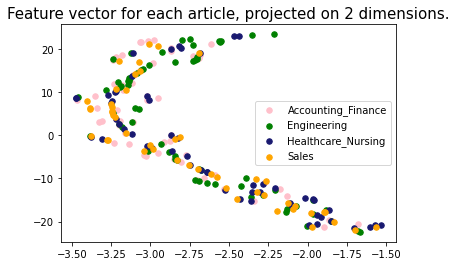

In [13]:
# explore feature space
features = bbcFT_dvs.to_numpy()
plotTSNE(job_ad['Category'],features)

### --------> OBSERVATION:

The unweighted embeding model seems does not do a good job of classifying features into their appropriate categories

In [14]:
# build the classfication model and report results
seed = 3879312
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(bbcFT_dvs, job_ad['Category'], list(range(0,len(job_ad))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 1000,random_state=seed)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.3151750972762646

## 4. Generating TF-IDF weighted document vectors

Ok, I hope you have lots of fun building document embeddings based on varoius word embedding models. 
Previously, when we generate the document embeddings, we just sum up the embeddings vector of each tokenized word in the article, a bit simplicity 🤔

In this section, let's make it a bit more challenging, we are going to build the tf-idfdocument embeddings. 
What does that mean? 🤨
Hmm~~ it's not magic, we just do a weigthed sum of the word embedding vectors, however, the weight here, refers to the tf-idfweight of the word. 

If you already forgot about what is `tf-ijob_ad`, please refer to Activity 3 Pre-processing Text and Generating Features. 
Otherwise, move on!
So we've generated the tf-idfvector representation of documents in Activity 3 and saved in a txt file called `bbcNews_tVector.txt`. The format of this file is:
- each line represents an article;
- each line is of the format 'w_index:weight w_index:weight ......' 

Oh, but we don't have that word index `w_index` here in this activity, what should we do? 🤔
ah ha, we also saved the vocabulary in a file `vocab`, in which each line is a word, and of the format `index,word`. 
Theresore, based on these two files, we can create a word:weight mapping for each tokenized word in a document!

Ok, in the following couple block of codes, this is exactly what we are trying to do, step by step. 
- the `gen_vocIndex` function reads the the vocabulary file, and create an w_index:word dictionary

In [15]:
def read_vocab(vocab_file):
    vocab = {}
    with open(vocab_file) as f:
        for line in f:
            (word, index) = line.split(':')
            vocab[word.strip()] = int(index)
    return {v: k for k, v in vocab.items()}

# Generates the w_index:word dictionary
voc_fname = 'vocab.txt'
voc_dict = read_vocab(voc_fname)
voc_dict

{0: 'aap',
 1: 'aaron',
 2: 'aat',
 3: 'abb',
 4: 'abenefit',
 5: 'aberdeen',
 6: 'abi',
 7: 'abilities',
 8: 'ability',
 9: 'abreast',
 10: 'abroad',
 11: 'absence',
 12: 'absolute',
 13: 'ac',
 14: 'aca',
 15: 'academic',
 16: 'academy',
 17: 'acca',
 18: 'accept',
 19: 'acceptable',
 20: 'acceptance',
 21: 'accepted',
 22: 'access',
 23: 'accessible',
 24: 'accident',
 25: 'accommodates',
 26: 'accommodation',
 27: 'accomplished',
 28: 'accordance',
 29: 'account',
 30: 'accountabilities',
 31: 'accountability',
 32: 'accountable',
 33: 'accountancy',
 34: 'accountant',
 35: 'accountants',
 36: 'accounting',
 37: 'accounts',
 38: 'accreditation',
 39: 'accredited',
 40: 'accruals',
 41: 'accuracy',
 42: 'accurate',
 43: 'accurately',
 44: 'achievable',
 45: 'achieve',
 46: 'achieved',
 47: 'achievement',
 48: 'achievements',
 49: 'achiever',
 50: 'achieving',
 51: 'acii',
 52: 'acquired',
 53: 'acquisition',
 54: 'acquisitions',
 55: 'act',
 56: 'acting',
 57: 'action',
 58: 'action

- the `doc_wordweights` function takes the tfijob_ad document vector file, as well as the w_index:word dictionary, creates the mapping between w_index and the actual word, and creates a dictionary of word:weight or each unique word appear in the document.

In [16]:
def doc_wordweights(fName_tVectors, voc_dict):
    tfidf_weights = [] # a list to store the  word:weight dictionaries of documents
    
    with open(fName_tVectors) as tVecf: 
        tVectors = tVecf.read().splitlines() # each line is a tfidf vector representation of a document in string format 'word_index:weight word_index:weight .......'
    for tv in tVectors: # for each tfidf document vector
        tv = tv.strip()
        weights = tv.split(' ') # list of 'word_index:weight' entries
        weights = [w.split(':') for w in weights] # change the format of weight to a list of '[word_index,weight]' entries
        wordweight_dict = {voc_dict[int(w[0])]:w[1] for w in weights} # construct the weight dictionary, where each entry is 'word:weight'
        tfidf_weights.append(wordweight_dict) 
    return tfidf_weights

fName_tVectors = 'jobAd_tVector.txt'
tfijob_ad_weights = doc_wordweights(fName_tVectors, voc_dict)

# take a look at the tfijob_ad word weights dictionary of the first document
tfijob_ad_weights[0]

{'terms': '0.12814828244060425',
 'successful': '0.05796079997740923',
 'south': '0.2018635293730571',
 'skills': '0.04913453192908334',
 'service': '0.060710119751583795',
 'sales': '0.06454174417506445',
 'role': '0.12135675890098277',
 'requirement': '0.12239855316060116',
 'reconciliation': '0.13890102583022776',
 'qualified': '0.07659552107697486',
 'purchase': '0.13378223582062956',
 'previous': '0.08075436746078549',
 'possess': '0.10743973778148354',
 'phone': '0.11676459978057582',
 'person': '0.08859627508123877',
 'permanent': '0.08005535336313394',
 'payment': '0.13538699349642683',
 'partqualified': '0.16974524253473644',
 'part': '0.07041212519192294',
 'offices': '0.1128037312357935',
 'negotiating': '0.15654960114068633',
 'modern': '0.1294543605339772',
 'manufacturing': '0.09525384009006171',
 'london': '0.16491288212112942',
 'letter': '0.12570538443617763',
 'ledger': '0.2675644716412591',
 'ideal': '0.08620541715836426',
 'handling': '0.23888098357149493',
 'fully'

Ok, once we have the word:weight dictionary of each document, now we can construct the tf-idf weighted document embeddings. 
* the following `gen_docVecs` function is an revision/extension of the previous written function, that takes the word embeddings dictionary, the tokenized text of articles, and the tfijob_ad weights (list of word:weight dictionaries, one for each article) as arguments, and generates the document embeddings:
 1. creates an empty dataframe `docs_vectors` to store the document embeddings of articles
  2. it loop through every tokenized text:
    - creates an empty dataframe `temp` to store all the word embeddings of the article
    - for each word that exists in the word embeddings dictionary/keyedvectors, 
        - if the argument `tfijob_ad` weights are empty `[]`, it sets the weight of the word as 1
        - otherwise, retrieve the weight of the word from the corresponding word:weight dictionary of the article from  `tfijob_ad`
    - row bind the weighted word embedding to `temp`
    - takes the sum of each column to create the document vector, i.e., the embedding of an article
    - append the created document vector to the list of document vectors

In [17]:
# extended version of the `gen_docVecs` function
def gen_docVecs(wv,tk_txts,tfijob_ad = []): # generate vector representation for documents
    docs_vectors = pd.DataFrame() # creating empty final dataframe
    #stopwords = nltk.corpus.stopwords.words('english') # removing stop words

    for i in range(0,len(tk_txts)):
        tokens = list(set(tk_txts[i])) # get the list of distinct words of the document

        temp = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
        for w_ind in range(0, len(tokens)): # looping through each word of a single document and spliting through space
            try:
                word = tokens[w_ind]
                word_vec = wv[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
                
                if tfijob_ad != []:
                    word_weight = float(tfijob_ad[i][word])
                else:
                    word_weight = 1
                temp = temp.append(pd.Series(word_vec*word_weight), ignore_index = True) # if word is present then append it to temporary dataframe
            except:
                pass
        doc_vector = temp.sum() # take the sum of each column(w0, w1, w2,........w300)
        docs_vectors = docs_vectors.append(doc_vector, ignore_index = True) # append each document value to the final dataframe
    return docs_vectors

Ok we now have everything ready to generate the weight document embeddings. 
We can do this on any of our previous explored models, including the pretrained Word2Vec GoogleNews300, Glove, our in-house trained Word2Vec and FastText.

Let's generated the weighted version of the document embedding vectors first

In [18]:
weighted_bbcFT_company = gen_docVecs_weight(bbcFT_wv,job_ad['Tokenized Company'],tfijob_ad_weights)
weighted_bbcFT_title = gen_docVecs_weight(bbcFT_wv,job_ad['Tokenized Title'],tfijob_ad_weights)
weighted_bbcFT_description = gen_docVecs_weight(bbcFT_wv,job_ad['Tokenized Description'],tfijob_ad_weights)

And we can do very much the same thing as what we do before for other models. 
Here, we will do this as loops, for each model:
- we plot out the feature vectors  projected in a 2-dimensional space,then 
- we build the logistic regression model for document classfication and report the model performance.

In [36]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
def plotTSNE(labels,features): # features as a numpy array, each element of the array is the document embedding of an article
    categories = sorted(labels.unique())
    # Sampling a subset of our dataset because t-SNE is computationally expensive
    SAMPLE_SIZE = int(len(features) * 0.3)
    np.random.seed(0)
    indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
    projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices].astype(int))
    colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
    for i in range(0,len(categories)):
        points = projected_features[(labels[indices] == categories[i])]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=categories[i])
    plt.title("Feature vector for each article, projected on 2 dimensions.",
              fontdict=dict(fontsize=15))
    plt.legend()
    plt.show()

In [43]:
%matplotlib inline
seed = 0
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

models = [weighted_bbcFT_company,weighted_bbcFT_title,weighted_bbcFT_description]
model_names = ["Weighted Pretrained FastText with Company", "Weighted Pretrained FastText with Title", "Weighted Pretrained FastText with Description"]
for i in range(0,len(models)): #loop through each model
    dv = models[i]
    name = model_names[i]
    features = dv.to_numpy() # convert the dataframe stored features to an numpy array
    print(len(features))
    # print(name + ": tSNE 2 dimensional projected Feature space")
    # plotTSNE(job_ad['Category'],features)
    
    # creating training and test split
    X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(dv, job_ad['Category'], list(range(0,len(job_ad))),test_size=0.33, random_state=seed)

    model = LogisticRegression(max_iter = 2000,random_state=seed)
    X_train = np.array(X_train).reshape(-1, 1)
    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)
    X_test = np.array(X_test).reshape(-1, 1)
    model.fit(X_train, y_train)
    print("Accuracy: ", model.score(X_test, y_test))
    print('\n\n')

0


ValueError: Found input variables with inconsistent numbers of samples: [0, 776, 776]

In [51]:
models = [weighted_bbcFT_company,weighted_bbcFT_title,weighted_bbcFT_description]
model_names = ["Weighted Pretrained FastText with Company", "Weighted Pretrained FastText with Title", "Weighted Pretrained FastText with Description"]
for i in range(0,len(models)):
    model = models[i]
    name = model_names[i]
    features = dv.to_numpy() # convert the dataframe stored features to an numpy array
    print(len(features))
    # creating training and test split
    X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(dv, job_ad['Category'], list(range(0,len(job_ad))),test_size=0.33, random_state=seed)
    model = LogisticRegression(max_iter = 2000,random_state=seed)
    model.fit(X_train, y_train)
    print(model_names[i] + " Accuracy: " + str(model.score(X_test, y_test)))

776
Weighted Pretrained FastText with Company Accuracy: 0.31906614785992216
776
Weighted Pretrained FastText with Title Accuracy: 0.31906614785992216
776
Weighted Pretrained FastText with Description Accuracy: 0.31906614785992216


776
Weighted Pretrained FastText with Description: tSNE 2 dimensional projected Feature space


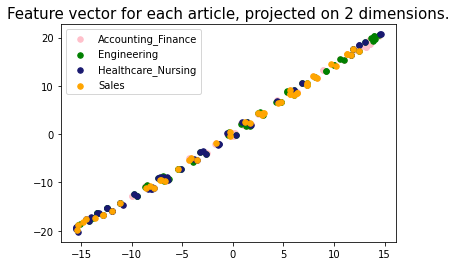

Accuracy:  0.31906614785992216





In [46]:
%matplotlib inline
seed = 0
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

models = weighted_bbcFT_description
model_names = "Weighted Pretrained FastText with Description"

dv = models
name = model_names
features = dv.to_numpy() # convert the dataframe stored features to an numpy array
print(len(features))
print(name + ": tSNE 2 dimensional projected Feature space")
plotTSNE(job_ad['Category'],features)
    
# creating training and test split
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(dv, job_ad['Category'], list(range(0,len(job_ad))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 2000,random_state=seed)
# X_train = np.array(X_train).reshape(-1, 1)
# y_train = np.array(y_train).reshape(-1, 1)
# y_test = np.array(y_test).reshape(-1, 1)
# X_test = np.array(X_test).reshape(-1, 1)
model.fit(X_train, y_train)
print("Accuracy: ", model.score(X_test, y_test))
print('\n\n')

In [34]:
type(features)

numpy.ndarray

In [39]:
job_ad.info()

0

#### Note: Creating tfijob_ad weighted document embeddings using Gensim

In the previous sections, we tried very hard to create the tfijob_ad weighted document embeddings using the generated tf-idfweights save in previous activity. 
Indeed, we can using Genism to do this direction, and it's indeed, a bit less effor required 😑 Will show you below. 
We will use the in-house build Word2Vec model as an example.

In [53]:
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel

# we have two vocabularies here, one from the in-house bulit Word2Vec, the other from the articles 
# note that althought the Word2Vec is built on the same dataset, but they might have done further 
# pre-processing during model build (e.g., setting min_count), and thus, might create mismatch in the two vocabularis. 
# therefore, we remove tokenized words that doesn't exist in the keyedvectors in the Word2Vec keyedvectors
processed_text = [[w for w in t if w in bbcFT_wv.index_to_key] for t in job_ad['Tokenized Description']] 

# use the Gensim package to create a dictionary that encapsulates the mapping between normalized words and their integer ids.
docs_dict = Dictionary(processed_text) # creates a dictionary from the text
docs_dict.filter_extremes(no_below=5) # filtering words that appear less than 5 times
docs_dict.compactify() # assign new word ids to all words, shrinking any gaps.

2022-10-02 20:07:04,435 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2022-10-02 20:07:04,519 : INFO : built Dictionary<2791 unique tokens: ['accountant', 'accounts', 'adhoc', 'administration', 'business']...> from 776 documents (total 96494 corpus positions)
2022-10-02 20:07:04,520 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<2791 unique tokens: ['accountant', 'accounts', 'adhoc', 'administration', 'business']...> from 776 documents (total 96494 corpus positions)", 'datetime': '2022-10-02T20:07:04.520175', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2022-10-02 20:07:04,521 : INFO : discarding 313 tokens: [('advisory', 4), ('experience', 586), ('partqualified', 4), ('findings', 4), ('role', 499), ('funds', 4), ('nav', 3), ('wellingborough', 3), ('imaging', 3), ('securities', 2)]...
2022-10-02 20:07:04,522 : INFO : keeping 2478 tokens which were i

In [54]:
# see what are the words that been get rid off when we do the fliter
[w for w in bbcFT_wv.index_to_key if w not in docs_dict.values()]

['experience',
 'role',
 'work',
 'team',
 'working',
 'ax',
 'nuclear',
 'asbestos',
 'foster',
 'securities',
 'flame',
 'axapta',
 'carillion',
 'bull',
 'gui',
 'courier',
 'carer',
 'voltage',
 'jan',
 'geotechnical',
 'yn',
 'french',
 'export',
 'barchester',
 'laundry',
 'ets',
 'andrew',
 'engines',
 'restaurant',
 'hall',
 'entertainment',
 'liquidity',
 'ipad',
 'canada',
 'programmer',
 'payable',
 'opentable',
 'pearce',
 'cancer',
 'reservoir',
 'cardiac',
 'exhaust',
 'inventor',
 'primavera',
 'radiology',
 'sharepoint',
 'dockyard',
 'inside',
 'fluid',
 'optometry',
 'debt',
 'hyperion',
 'renewals',
 'interventional',
 'surface',
 'balances',
 'icu',
 'pqe',
 'microwave',
 'psp',
 'dutch',
 'dc',
 'wedbush',
 'architecture',
 'assisted',
 'funds',
 'operators',
 'drives',
 'citizens',
 'furniture',
 'guaranteed',
 'fostering',
 'midwifery',
 'iphone',
 'hcone',
 'military',
 'valuation',
 'optimisation',
 'crawley',
 'aftermarket',
 'handbook',
 'planner',
 'intruder

In [55]:
len(docs_dict.keys())

2478

This process yields a vocabulary with 8647 words. 
Then we use Gensim again to create a bag-of-words representation of each document, i.e., the tf-idfvector for each document.


In [57]:
import numpy as np
from gensim.matutils import sparse2full

docs_corpus = [docs_dict.doc2bow(doc) for doc in job_ad['Tokenized Description']] # convert corpus to Bag of Word format
model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict) # fit the tfijob_ad model
# apply model to the list of corpus document, 
# so each document is a list of tuples, (word_index, weight) for each word appears in the document
docs_tfidf  = model_tfidf[docs_corpus]

2022-10-02 20:09:04,426 : INFO : collecting document frequencies
2022-10-02 20:09:04,427 : INFO : PROGRESS: processing document #0
2022-10-02 20:09:04,439 : INFO : TfidfModel lifecycle event {'msg': 'calculated IDF weights for 776 documents and 2478 features (66638 matrix non-zeros)', 'datetime': '2022-10-02T20:09:04.439665', 'gensim': '4.2.0', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'initialize'}


In [58]:
# see for example, the tfijob_ad weights of the words in the 2nd document
docs_tfidf[1]

[(0, 0.15534149017299),
 (5, 0.028591951072389266),
 (7, 0.07991685103703668),
 (13, 0.05186359644127443),
 (26, 0.04874146350047371),
 (31, 0.037910150934043686),
 (40, 0.1006373390775577),
 (46, 0.02674167375997385),
 (48, 0.22342352912688343),
 (49, 0.22487519738614636),
 (50, 0.0692371541104755),
 (51, 0.02493115802878268),
 (52, 0.03487664919513352),
 (53, 0.07082071720008046),
 (54, 0.07082071720008046),
 (55, 0.10907093005357718),
 (56, 0.04383517549337781),
 (57, 0.8260762772273114),
 (58, 0.07082071720008046),
 (59, 0.08930844698478826),
 (60, 0.0957708679898628),
 (61, 0.02819090658875632),
 (62, 0.03004840404971423),
 (63, 0.11849073089420593),
 (64, 0.07432381471517505),
 (65, 0.09890805031297811),
 (66, 0.0769646492250396),
 (67, 0.09298302575364399),
 (68, 0.04742196171891531),
 (69, 0.05823591041524185),
 (70, 0.06823443058006264),
 (71, 0.07432381471517505),
 (72, 0.037910150934043686),
 (73, 0.06501066873910928),
 (74, 0.077670745086495),
 (75, 0.04536632294554338),
 (

We can then transfer `docs_tfidf` to matrix form. `vstack` function from numpy can stack arrays in sequence vertically (row wise), and `sparse2full` function convert a document in sparse document format (in size of the number of words in the document) into a dense numpy array (of size of the vocabulary)

In [59]:
docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])

In [60]:
docs_vecs.shape

(776, 2478)

In [61]:
docs_vecs[0]

array([0.36338544, 0.2579631 , 0.1471216 , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

The result, `docs_vecs`, is a matrix with 2225 rows (docs) and 8647 columns (tf-idfterms). 

Let's see the performance of this tf-idfvector:

In [62]:
# creating training and test split
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(docs_vecs, job_ad['Category'], list(range(0,len(job_ad))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 1000,random_state=seed)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9066147859922179

Wow~ quite good!

Now try to use this tfijob_ad vector to create the weighted document embeddings.

Be careful, the vocabulary are different, for instance, 

In [63]:
# see how many words are encoded in our in-house Word2Vec model?
len(bbcFT_wv.index_to_key)

2791

In [64]:
# how about the tfijob_ad vector?
len(docs_dict)

2478

We only care about words that are in both vocabulary. 
In the following, we creates the word embeddings arrays for words exists in docs_dict

In [65]:
word_emb_vecs = np.vstack([bbcFT_wv[docs_dict[i]] for i in range(len(docs_dict)) if docs_dict[i] in bbcFT_wv.index_to_key])

In [66]:
word_emb_vecs.shape

(2478, 300)

In [67]:
word_emb_vecs[0]

array([-3.71768773e-01, -2.36117467e-01, -7.98417032e-02,  5.68372488e-01,
       -3.82480145e-01, -5.84834516e-01, -6.20643258e-01,  7.41477534e-02,
       -2.05583081e-01,  7.53869638e-02, -9.34315473e-03, -4.94218543e-02,
        5.41928709e-01,  1.09348714e-01,  2.22343370e-01, -4.51983251e-02,
       -1.23814158e-01, -3.20926398e-01, -6.13846362e-01,  7.79627040e-02,
        6.37130558e-01,  1.05689907e+00,  1.00493455e+00,  2.06048086e-01,
        1.36156037e-01, -7.15225562e-02, -2.42524147e-01, -4.26699281e-01,
        4.68896985e-01, -2.51269042e-01,  7.31782556e-01,  2.52266079e-01,
       -3.49685282e-01, -5.66327333e-01,  1.14656724e-01, -2.25211103e-02,
        3.29363018e-01,  1.55971125e-01, -6.55001104e-02, -3.30451638e-01,
       -7.47609958e-02,  5.06386459e-01, -1.17530618e-02, -3.48129086e-02,
        1.05534136e+00, -4.50232655e-01,  5.29071912e-02, -5.54019511e-01,
       -5.42833149e-01,  3.70577037e-01,  2.68370360e-01, -2.28973582e-01,
        5.50188459e-02,  

Now we can do the dot product of the two vectors and get our tfijob_ad weighted document embeddings:

In [68]:
tfijob_ad_docs_emb = np.dot(docs_vecs, word_emb_vecs) 

In [69]:
# creating training and test split
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(tfijob_ad_docs_emb, job_ad['Category'], list(range(0,len(job_ad))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 1000,random_state=seed)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8715953307392996

Not much difference from the one we did ourselves (refer to the performance of the `Weighted In-house Word2Vec`.
Comparing the performance of the tfijob_ad weighted document emeddings with our in-house built Word2Vec and the non-weighted on (referring to Section 2), adding the tfijob_ad weight indeed worsen the results in this example. 
Indeed, in this example, the most simply bag-of-word tfijob_ad vector representatino words much better, i.e., 0.978 accuracy 😆

> **Discussion**
Does adding the tfijob_ad weight to construct document embedding and/or having a more complicated model guarantees higher performance?


Cool! 🤩 It gets the right class (I hope you got the same, but maybe you have different results....)
Try as many as you want and have fun! 😊

If you run the infer_vecotr multiple time, every time you get a different vector. and thus, when you predict the class based on the different document vectors, you may get different results. 🤪 🤪 🤪 
Refer to the answer of the [this question](https://github.com/RaRe-Technologies/gensim/wiki/recipes-&-faq#q12-ive-used-doc2vec-infer_vector-on-a-single-text-but-the-resulting-vector-is-different-each-time-is-there-a-bug-or-have-i-made-a-mistake-doc2vec-inference-non-determinism) to understand why. 


## Summary

Phew~~ this is a big activity. I got exhausted written it up and I believe you got a bit exhaused looking through it too 🤣
Give yourself a clap! Well done! 👏👏👏



## Exericse:
Ok, we leave a few exercises for you:
- We have try vector size 100 so far, but there are many alternatives, e.g., 50,200,300. Try other size and report performance. Discuss and share your thoughts with your peers: does larger vector size guarantees better performance?
- So far, in this activities, we have been using the cleaned articles. Many of these libraries (including Genism) has included functionalities to do simply cleaning of text. Try them on and compare the performance.
- Oh, one other very important thing. The results we presented so for in this activity, are based on a single run. To report more robust results, you should do Cross validation. Implement cross validation on the models we explore in this activity, and do a comprehensive comparsion on them.
    


## References
[1] [TFIjob_ad with Word Embeddings](https://github.com/ytnvj2/DocumentEmbedding/blob/master/TFIjob_adwithEmbeddings.ipynb)  
[2] [Problem-solving with ML: automatic document classification](https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification)     
[3] [Creating tf-idfWeighted Word Embeddings](http://dsgeek.com/2018/02/19/tfijob_ad_vectors.html)    